## VDMS multi-modal RAG

Many documents contain a mixture of content types, including text and images. 

Yet, information captured in images is lost in most RAG applications.

With the emergence of multimodal LLMs, like [GPT-4V](https://openai.com/research/gpt-4v-system-card), it is worth considering how to utilize images in RAG. 

This cookbook highlights: 
* Use of [Unstructured](https://unstructured.io/) to parse images, text, and tables from documents (PDFs).
* Use of multimodal embeddings (such as [CLIP](https://openai.com/research/clip)) to embed images and text
* Use of [VDMS](https://github.com/IntelLabs/vdms/blob/master/README.md) as a vector store with support for multi-modal
* Retrieval of both images and text using similarity search
* Passing raw images and text chunks to a multimodal LLM for answer synthesis 


## Packages

For `unstructured`, you will also need `poppler` ([installation instructions](https://pdf2image.readthedocs.io/en/latest/installation.html)) and `tesseract` ([installation instructions](https://tesseract-ocr.github.io/tessdoc/Installation.html)) in your system.

In [1]:
# (newest versions required for multi-modal)
! pip install --quiet -U vdms langchain-experimental

# lock to 0.10.19 due to a persistent bug in more recent versions
! pip install --quiet pdf2image "unstructured[all-docs]==0.10.19" pillow pydantic lxml open_clip_torch

## Start VDMS Server

Let's start a VDMS docker using port 55559 instead of default 55555. 
Keep note of the port and hostname as this is needed for the vector store as it uses the VDMS Python client to connect to the server.

In [3]:
! docker run --rm -d -p 55559:55555 --name vdms_rag_nb intellabs/vdms:latest

# Connect to VDMS Vector Store
from langchain_community.vectorstores.vdms import VDMS_Client

vdms_client = VDMS_Client(port=55559)

docker: Error response from daemon: Conflict. The container name "/vdms_rag_nb" is already in use by container "0c19ed281463ac10d7efe07eb815643e3e534ddf24844357039453ad2b0c27e8". You have to remove (or rename) that container to be able to reuse that name.
See 'docker run --help'.


In [ ]:
# from dotenv import load_dotenv, find_dotenv
# load_dotenv(find_dotenv(), override=True);

## Data Loading

### Partition PDF text and images
  
Let's look at an example pdf containing interesting images.

Famous photographs from library of congress:

* https://www.loc.gov/lcm/pdf/LCM_2020_1112.pdf
* We'll use this as an example below

We can use `partition_pdf` below from [Unstructured](https://unstructured-io.github.io/unstructured/introduction.html#key-concepts) to extract text and images.

In [4]:
from pathlib import Path

import requests

# Folder with pdf and extracted images
datapath = Path("./multimodal_files").resolve()
datapath.mkdir(parents=True, exist_ok=True)

pdf_url = "https://www.loc.gov/lcm/pdf/LCM_2020_1112.pdf"
pdf_path = str(datapath / pdf_url.split("/")[-1])
with open(pdf_path, "wb") as f:
    f.write(requests.get(pdf_url).content)

In [5]:
# Extract images, tables, and chunk text
from unstructured.partition.pdf import partition_pdf

raw_pdf_elements = partition_pdf(
    filename=pdf_path,
    extract_images_in_pdf=True,
    infer_table_structure=True,
    chunking_strategy="by_title",
    max_characters=4000,
    new_after_n_chars=3800,
    combine_text_under_n_chars=2000,
    image_output_dir_path=datapath,
)

datapath = str(datapath)

In [6]:
# Categorize text elements by type
tables = []
texts = []
for element in raw_pdf_elements:
    if "unstructured.documents.elements.Table" in str(type(element)):
        tables.append(str(element))
    elif "unstructured.documents.elements.CompositeElement" in str(type(element)):
        texts.append(str(element))

## Multi-modal embeddings with our document

We will use [OpenClip multimodal embeddings](https://python.langchain.com/docs/integrations/text_embedding/open_clip).

We use a larger model for better performance (set in `langchain_experimental.open_clip.py`).

```
model_name = "ViT-g-14"
checkpoint = "laion2b_s34b_b88k"
```

In [7]:
import os

from langchain_community.vectorstores import VDMS
from langchain_experimental.open_clip import OpenCLIPEmbeddings

# Create VDMS
vectorstore = VDMS(
    client=vdms_client,
    collection_name="mm_rag_clip_photos",
    embedding_function=OpenCLIPEmbeddings(
        model_name="ViT-g-14", checkpoint="laion2b_s34b_b88k"
    ),
)

# Get image URIs with .jpg extension only
image_uris = sorted(
    [
        os.path.join(datapath, image_name)
        for image_name in os.listdir(datapath)
        if image_name.endswith(".jpg")
    ]
)

# Add images
if image_uris:
    vectorstore.add_images(uris=image_uris)

# Add documents
if texts:
    vectorstore.add_texts(texts=texts)

# Make retriever
retriever = vectorstore.as_retriever()

## RAG

`vectorstore.add_images` will store / retrieve images as base64 encoded strings.

In [8]:
import base64
from io import BytesIO

from PIL import Image


def resize_base64_image(base64_string, size=(128, 128)):
    """
    Resize an image encoded as a Base64 string.

    Args:
    base64_string (str): Base64 string of the original image.
    size (tuple): Desired size of the image as (width, height).

    Returns:
    str: Base64 string of the resized image.
    """
    # Decode the Base64 string
    img_data = base64.b64decode(base64_string)
    img = Image.open(BytesIO(img_data))

    # Resize the image
    resized_img = img.resize(size, Image.LANCZOS)

    # Save the resized image to a bytes buffer
    buffered = BytesIO()
    resized_img.save(buffered, format=img.format)

    # Encode the resized image to Base64
    return base64.b64encode(buffered.getvalue()).decode("utf-8")


def is_base64(s):
    """Check if a string is Base64 encoded"""
    try:
        return base64.b64encode(base64.b64decode(s)) == s.encode()
    except Exception:
        return False


def split_image_text_types(docs):
    """Split numpy array images and texts"""
    images = []
    text = []
    for doc in docs:
        doc = doc.page_content  # Extract Document contents
        if is_base64(doc):
            # Resize image to avoid OAI server error
            images.append(
                resize_base64_image(doc, size=(250, 250))
            )  # base64 encoded str
        else:
            text.append(doc)
    return {"images": images, "texts": text}

Currently, we format the inputs using a `RunnableLambda` while we add image support to `ChatPromptTemplates`.

Our runnable follows the classic RAG flow - 

* We first compute the context (both "texts" and "images" in this case) and the question (just a RunnablePassthrough here) 
* Then we pass this into our prompt template, which is a custom function that formats the message for the llava model. 
* And finally we parse the output as a string.

Here we are using Ollama to serve the Llava model. Please see [Ollama](https://python.langchain.com/docs/integrations/llms/ollama) for setup instructions.

In [9]:
from langchain_community.llms.ollama import Ollama
from langchain_core.messages import HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableLambda, RunnablePassthrough


def prompt_func(data_dict):
    # Joining the context texts into a single string
    formatted_texts = "\n".join(data_dict["context"]["texts"])
    messages = []

    # Adding image(s) to the messages if present
    if data_dict["context"]["images"]:
        image_message = {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{data_dict['context']['images'][0]}"
            },
        }
        messages.append(image_message)

    # Adding the text message for analysis
    text_message = {
        "type": "text",
        "text": (
            "As an expert art critic and historian, your task is to analyze and interpret images, "
            "considering their historical and cultural significance. Alongside the images, you will be "
            "provided with related text to offer context. Both will be retrieved from a vectorstore based "
            "on user-input keywords. Please convert answers to english and use your extensive knowledge "
            "and analytical skills to provide a comprehensive summary that includes:\n"
            "- A detailed description of the visual elements in the image.\n"
            "- The historical and cultural context of the image.\n"
            "- An interpretation of the image's symbolism and meaning.\n"
            "- Connections between the image and the related text.\n\n"
            f"User-provided keywords: {data_dict['question']}\n\n"
            "Text and / or tables:\n"
            f"{formatted_texts}"
        ),
    }
    messages.append(text_message)
    return [HumanMessage(content=messages)]


def multi_modal_rag_chain(retriever):
    """Multi-modal RAG chain"""

    # Multi-modal LLM
    llm_model = Ollama(
        verbose=True, temperature=0.5, model="llava", base_url="http://localhost:11434"
    )

    # RAG pipeline
    chain = (
        {
            "context": retriever | RunnableLambda(split_image_text_types),
            "question": RunnablePassthrough(),
        }
        | RunnableLambda(prompt_func)
        | llm_model
        | StrOutputParser()
    )

    return chain

## Test retrieval and run RAG

GREAT PHOTOGRAPHS
The subject of the photo, Florence Owens Thompson, a Cherokee from Oklahoma, initially regretted that Lange ever made this photograph. “She was a very strong woman. She was a leader,” her daughter Katherine later said. “I think that's one of the reasons she resented the photo — because it didn't show her in that light.”

DOROTHEA LANGE. “DESTITUTE PEA PICKERS IN CALIFORNIA. MOTHER OF SEVEN CHILDREN. AGE THIRTY-TWO. NIPOMO, CALIFORNIA.” MARCH 1936. NITRATE NEGATIVE. FARM SECURITY ADMINISTRATION-OFFICE OF WAR INFORMATION COLLECTION. PRINTS AND PHOTOGRAPHS DIVISION.

—Helena Zinkham

—Helena Zinkham

NOVEMBER/DECEMBER 2020 LOC.GOV/LCM



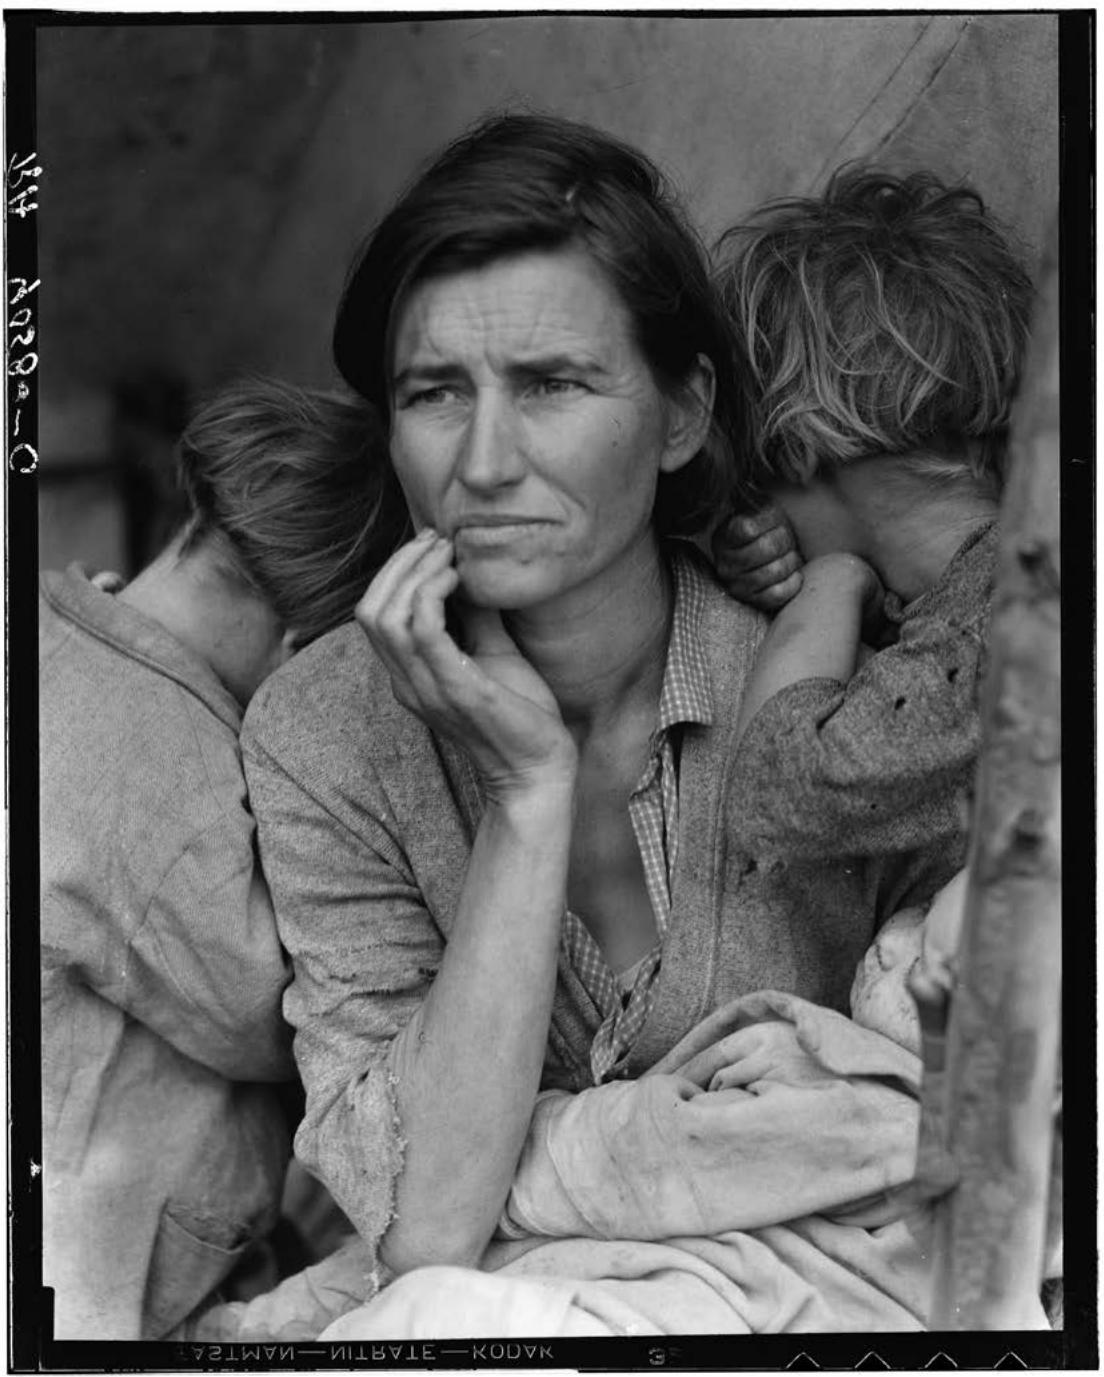

In [10]:
from IPython.display import HTML, display


def plt_img_base64(img_base64):
    # Create an HTML img tag with the base64 string as the source
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'

    # Display the image by rendering the HTML
    display(HTML(image_html))


query = "Woman with children"
docs = retriever.invoke(query, k=10)

for doc in docs:
    if is_base64(doc.page_content):
        plt_img_base64(doc.page_content)
    else:
        print(doc.page_content)

In [11]:
chain = multi_modal_rag_chain(retriever)
response = chain.invoke(query)
print(response)

1. Detailed description of the visual elements in the image: The image features a woman with children, likely a mother and her family, standing together outside. They appear to be poor or struggling financially, as indicated by their attire and surroundings.
2. Historical and cultural context of the image: The photo was taken in 1936 during the Great Depression, when many families struggled to make ends meet. Dorothea Lange, a renowned American photographer, took this iconic photograph that became an emblem of poverty and hardship experienced by many Americans at that time.
3. Interpretation of the image's symbolism and meaning: The image conveys a sense of unity and resilience despite adversity. The woman and her children are standing together, displaying their strength as a family unit in the face of economic challenges. The photograph also serves as a reminder of the importance of empathy and support for those who are struggling.
4. Connections between the image and the related text

In [12]:
! docker kill vdms_rag_nb

vdms_rag_nb
